In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, classification_report
import time
#import pydotplus

## Predict Default Probability of Expired Loans
We want to try different models to predict loans that have expired

In [2]:
df1 = pd.read_excel('2007_2011.xlsx',sheetname='Sheet1')
df2 = pd.read_excel('2012_2013.xlsx',sheetname='Sheet1')
df3 = pd.read_excel('2014.xlsx',sheetname='Sheet1')


In [3]:
date_before_36 = datetime.date(2014,10,1)
date_before_60 = datetime.date(2012,10,1)
date_since_2009 = datetime.date(2010,1,1)
df1 = df1[df1.issue_d > date_since_2009]
df2 = df2[((df2.term.str.contains('60')) & (df2.issue_d < date_before_60)) | (df2.term.str.contains('36'))]
df3 = df3[(df3.term.str.contains('36')) & (df3.issue_d < date_before_36)]

In [4]:
data = pd.concat([df1,df2,df3],join='inner')

data = data[['id','loan_amnt','funded_amnt','funded_amnt_inv','term','int_rate',
         'installment','grade','sub_grade','emp_title','emp_length',
         'home_ownership','annual_inc','verification_status','issue_d',
         'loan_status','purpose','title','zip_code','addr_state','dti',
        'delinq_2yrs','earliest_cr_line','open_acc','pub_rec','last_pymnt_d',
        'last_pymnt_amnt','last_fico_range_high','last_fico_range_low','application_type',
             'revol_bal','revol_util']]

data.dropna(subset=['annual_inc','loan_status','issue_d','last_pymnt_d','loan_amnt',
                          'int_rate','earliest_cr_line','open_acc','pub_rec','delinq_2yrs',
                          'grade','last_fico_range_high','last_fico_range_low','installment',
                         'funded_amnt','dti','funded_amnt_inv','revol_bal']
            ,inplace=True)

print(data.shape)

(296143, 32)


## Feature Extraction (Binary)

In [6]:
# create labels for the dataset
data['duration'] = (data.last_pymnt_d - data.issue_d) / np.timedelta64(1, 'M')
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data_early = data[data.loan_status.str.contains('Fully Paid')]

data_early['label'] = 0
data_early.loc[((data_early.term.str.contains('36')) & (data_early.duration/36 < 0.85) &
             (data_early.loan_status.str.contains('Fully Paid'))), 'label'] = 1
data_early.loc[((data_early.term.str.contains('60')) & (data_early.duration/60 < 0.8)),
               'label'] = 1
# clean and get training/testing data 
temp = pd.get_dummies(data_early[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X = data_early.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X = np.concatenate((X,temp.as_matrix()),axis=1)
y = data_early.label.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
print(X_train.shape)
print(X_test.shape)

/Users/jeol/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/jeol/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:465: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(179389, 62)
(76882, 62)


## Feature Extraction (Multi-label)
Now we want to use the following set of features for prediction model.
loan_amnt, funded amnt (investor), term (category), int_rate, installment, grade (category), emp_length (category), home_ownership (category), annual_inc, verification_status (category), purpose (category), dti, delinq_2yrs, earliest_cr_line (up to issue_d), open_acc, pub_rec, fico_high, fico_low

In [32]:
# create labels for the dataset
data['duration'] = (data.last_pymnt_d - data.issue_d) / np.timedelta64(1, 'M')
data['label'] = (data.loan_status.str.contains('Charged Off') | 
                data.loan_status.str.contains('Default') | 
                data.loan_status.str.contains('Late'))
data['cr_hist'] = (data.issue_d - data.earliest_cr_line) / np.timedelta64(1, 'M')
data.label = data.label.astype(int)
data.set_value(index=((data.term.str.contains('36')) & (data.duration/36 < 0.85) &
             (data.loan_status.str.contains('Fully Paid'))), col='label',value=2)
data.set_value(index=((data.term.str.contains('60')) & (data.duration/60 < 0.8) &
             (data.loan_status.str.contains('Fully Paid'))), col='label',value=2)

# clean and get training/testing data 
temp = pd.get_dummies(data[['term','grade','emp_length','home_ownership',
                                  'verification_status','purpose']],dummy_na=True)
X = data.as_matrix(columns=['loan_amnt','funded_amnt_inv','int_rate','installment',
                                       'annual_inc','dti','delinq_2yrs','open_acc','pub_rec',
                                       'last_fico_range_high','last_fico_range_low','cr_hist'])
X = np.concatenate((X,temp.as_matrix()),axis=1)
y = data.label.as_matrix()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=24)
print(X_train.shape)
print(X_test.shape)

(207300, 62)
(88843, 62)


In [8]:
from sklearn import preprocessing

min_max_scaler = preprocessing.MinMaxScaler()
X_train_minmax = min_max_scaler.fit_transform(X_train)
X_test_minmax = min_max_scaler.transform(X_test)

## Prediction of Default
### Logistic Regression with cross-validation

In [35]:
from sklearn.linear_model import LogisticRegressionCV

time_start = time.clock()
logisticModel = LogisticRegressionCV(cv=10,multi_class='multinomial')
logisticModel.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)

computation time:  1777.244221


In [17]:
np.argsort(logisticModel.coef_)

array([[ 9,  4,  6,  2, 59,  0, 36,  1, 16, 15, 17, 46, 45, 35, 22, 49, 38,
        41, 60, 14, 31, 29, 27, 24, 28, 32, 26, 30, 25, 51, 23, 33, 52, 55,
        50, 18, 54, 47, 58, 48, 12, 53, 19, 44, 42, 43, 57, 37, 20, 39, 21,
        40, 34, 56, 10, 13,  7, 11,  8,  3,  5]])

In [33]:
print(logisticModel.coef_[0,6])
print(logisticModel.coef_[0,8])

-3.84946890517
3.12741998481


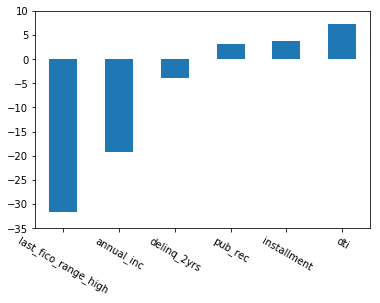

In [51]:
bplot = pd.Series(logisticModel.coef_[0,[9,4,6,8,3,5]])
xticks = ['last_fico_range_high','annual_inc','delinq_2yrs','pub_rec','installment','dti']
p1 = bplot.plot(kind='bar',rot=-30,ylim=(-35,10))
p1.set_xticklabels(xticks)
plt.show()

In [36]:
y_pred = logisticModel.predict(X_test_minmax)
print('Logistic Regression')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
#print('AUC: ',roc_auc_score(y_test,y_pred))

Logistic Regression
Accuracy:  0.531949618991

                precision    recall  f1-score   support

Non-Early-Paid     0.4925    0.3427    0.4042     36707
     Defaulted     0.5828    0.5968    0.5897     11929
    Early-Paid     0.5395    0.6855    0.6038     40207

   avg / total     0.5259    0.5319    0.5194     88843



### Support Vector Machine

In [ ]:
from sklearn.svm import SVC
svcModel = SVC(kernel='rbf')
svcModel.fit(X_train_minmax,y_train)

In [ ]:
y_pred = svcModel.predict(X_test_minmax)
print('SVM (RBF Kernel)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

### Random Forest

In [9]:
from sklearn.ensemble import RandomForestClassifier

time_start = time.clock()
rf_Gini = RandomForestClassifier(max_depth=12,random_state=0)
rf_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)

computation time:  2.5936100000000124


In [10]:
y_pred = rf_Gini.predict(X_test_minmax)
print('Random Forest (Gini)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))
#print('AUC: ',roc_auc_score(y_test,y_pred))

Random Forest (Gini)
Accuracy:  0.563603964517

                precision    recall  f1-score   support

Non-Early-Paid     0.5499    0.4100    0.4698     36249
     Defaulted     0.5710    0.7006    0.6292     40633

   avg / total     0.5611    0.5636    0.5540     76882



In [37]:
rf_Entro = RandomForestClassifier(criterion='entropy',max_depth=10,random_state=0)
rf_Entro.fit(X_train_minmax,y_train)
y_pred = rf_Entro.predict(X_test_minmax)
print('Random Forest (Entropy)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

Random Forest (Entropy)
Accuracy:  0.534819850748

                precision    recall  f1-score   support

Non-Early-Paid     0.4974    0.2483    0.3312     36707
     Defaulted     0.5344    0.7289    0.6167     11929
    Early-Paid     0.5476    0.7388    0.6290     40207

   avg / total     0.5251    0.5348    0.5043     88843



### Decision Trees

In [39]:
from sklearn.tree import DecisionTreeClassifier

tree_Gini = DecisionTreeClassifier(max_depth=10)
time_start = time.clock()
tree_Gini.fit(X_train_minmax,y_train)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
y_pred = tree_Gini.predict(X_test_minmax)
print('Decision Tree (Gini)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

computation time:  2.6116609999999127
Decision Tree (Gini)
Accuracy:  0.528313992098

                precision    recall  f1-score   support

Non-Early-Paid     0.4856    0.3445    0.4031     36707
     Defaulted     0.5379    0.7007    0.6086     11929
    Early-Paid     0.5487    0.6450    0.5929     40207

   avg / total     0.5212    0.5283    0.5166     88843



In [40]:
tree_Entro = DecisionTreeClassifier(max_depth=8,criterion='entropy')
tree_Entro.fit(X_train_minmax,y_train)
y_pred = tree_Gini.predict(X_test_minmax)
print('Decision Tree (Entropy)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

Decision Tree (Entropy)
Accuracy:  0.528313992098

                precision    recall  f1-score   support

Non-Early-Paid     0.4856    0.3445    0.4031     36707
     Defaulted     0.5379    0.7007    0.6086     11929
    Early-Paid     0.5487    0.6450    0.5929     40207

   avg / total     0.5212    0.5283    0.5166     88843



### Naive Bayes

In [41]:
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB

gnb = GaussianNB()
time_start = time.clock()
y_pred = gnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
time_elapsed = (time.clock() - time_start)
print('computation time: ', time_elapsed)
print('Naive Bayes (Gaussian)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

computation time:  0.42754999999988286
Naive Bayes (Gaussian)
Accuracy:  0.472293821685

                precision    recall  f1-score   support

Non-Early-Paid     0.4562    0.2502    0.3232     36707
     Defaulted     0.3916    0.4028    0.3971     11929
    Early-Paid     0.4956    0.6957    0.5788     40207

   avg / total     0.4654    0.4723    0.4488     88843



In [42]:
mnb = MultinomialNB()
y_pred = mnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('Naive Bayes (Multinomial)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

Naive Bayes (Multinomial)
Accuracy:  0.466688427901

                precision    recall  f1-score   support

Non-Early-Paid     0.4703    0.2863    0.3559     36707
     Defaulted     0.3346    0.0974    0.1509     11929
    Early-Paid     0.4727    0.7410    0.5772     40207

   avg / total     0.4532    0.4667    0.4285     88843



In [43]:
bnb = BernoulliNB()
y_pred = bnb.fit(X_train_minmax,y_train).predict(X_test_minmax)
print('Naive Bayes (Bernoulli)')
print('Accuracy: ',accuracy_score(y_test,y_pred))
print()
target_names = ['Non-Early-Paid','Defaulted','Early-Paid']
print(classification_report(y_test,y_pred,target_names=target_names,digits=4))

Naive Bayes (Bernoulli)
Accuracy:  0.469142194658

                precision    recall  f1-score   support

Non-Early-Paid     0.4677    0.3691    0.4126     36707
     Defaulted     0.3883    0.2089    0.2717     11929
    Early-Paid     0.4796    0.6377    0.5475     40207

   avg / total     0.4624    0.4691    0.4547     88843



## Prediction of Early Repayment

In [57]:
from statsmodels.regression.linear_model import OLS

data['duration'] = (data.last_pymnt_d - data.issue_d) / np.timedelta64(1, 'M')
data_early = data[data.loan_status.str.contains('Paid')]
print(data_early.shape)

(298184, 35)


In [58]:
y_early = data_early.duration
X_early = np.ones((data_early.shape[0],2))
X_early[:,1] = data_early.int_rate
model = OLS(y_early,X_early)
ols_result = model.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.006
Method:                 Least Squares   F-statistic:                     1936.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        00:44:38   Log-Likelihood:            -1.0649e+06
No. Observations:              298184   AIC:                         2.130e+06
Df Residuals:                  298182   BIC:                         2.130e+06
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.3776      0.046    332.070      0.0

In [63]:
X_early_2 = np.ones((data_early.shape[0],5))
X_early_2[:,1] = data_early.int_rate
X_early_2[:,2] = data_early.term.str.contains('36')
X_early_2[:,3] = data_early.last_fico_range_high
X_early_2[:,4] = data_early.loan_amnt
X_early_2 = min_max_scaler.fit_transform(X_early_2)
X_early_2[:,0] = 1
model = OLS(y_early,X_early_2)
ols_result = model.fit()
print(ols_result.summary())

                            OLS Regression Results                            
Dep. Variable:               duration   R-squared:                       0.031
Model:                            OLS   Adj. R-squared:                  0.031
Method:                 Least Squares   F-statistic:                     2408.
Date:                Mon, 04 Dec 2017   Prob (F-statistic):               0.00
Time:                        01:01:42   Log-Likelihood:            -1.0612e+06
No. Observations:              298184   AIC:                         2.122e+06
Df Residuals:                  298179   BIC:                         2.122e+06
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         15.2554      0.246     62.091      0.0